In [1]:
# A Jupyter notebook for training and qualitatively testing the NN sampling method for IC radiation
# Included also: our pre-trained model for the IC interaction

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from bisect import bisect_left
from bisect import bisect_right
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# usetex and serif font for plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [2]:
# Defining some physical quantities & helper functions for numerical calculation of IC interactions

def b(electronLorentz, photonEnergy): # dimensionless
    return 4 * electronLorentz * photonEnergy

def dsig_domega_iso(outgoingEnergy, electronEnergy, photonEnergy): # dimensionless
    z = outgoingEnergy / electronEnergy
    bT = b(electronEnergy, photonEnergy)
    return (3 / (bT * electronEnergy)) \
        * (1 + z*z / (2 * (1 - z)) \
            + z / (bT * (1 - z)) \
            - 2*z*z / (bT*bT * (1 - z)**2) \
            - z**3 / (2*bT*(1 - z)**2) \
            - (2*z / (bT*(1-z)))*np.log(bT * (1-z) / z))

def scatteringRate_iso(outgoingEnergy, electronEnergy, photonEnergy):
    if(not isinstance(outgoingEnergy, float)):
        E1 = outgoingEnergy / electronEnergy
        G = 4 * electronEnergy * photonEnergy
        q = E1 / (G * (1 - E1))
        rate = (1 / (electronEnergy * photonEnergy)) \
            * (2*q*np.log(q) + (1 + 2*q)*(1 - q) + 0.5*(G * q)**2 * (1 - q) / (1 + G*q))
        rate[outgoingEnergy < photonEnergy] = 0
        outMax = outMax_fn(electronEnergy, photonEnergy)
        rate[outgoingEnergy > outMax] = 0
        return rate
    else:
        if(outgoingEnergy < photonEnergy):
            return 0
        else:
            E1 = outgoingEnergy / electronEnergy
            G = 4 * electronEnergy * photonEnergy
            q = E1 / (G * (1 - E1))
            return (1 / (electronEnergy * photonEnergy)) \
                * (2*q*np.log(q) + (1 + 2*q)*(1 - q) + 0.5*(G * q)**2 * (1 - q) / (1 + G*q))

def scatteringRate_iso_norm(electronEnergy, photonEnergy, N):
        outMax = outMax_fn(electronEnergy, photonEnergy)
        outMin = photonEnergy
        x_axis1 = np.logspace(np.log10(outMin), np.log10(outMax*0.1), int(N/2))
        x_axis2 = np.linspace(outMax*0.1, outMax, int(N/2))
        x_axis = np.concatenate((x_axis1, x_axis2))
        outgoingEnergy = x_axis
        y = scatteringRate_iso(outgoingEnergy, electronEnergy, photonEnergy)
        return y, outgoingEnergy

def outMax_fn(electronEnergy, photonEnergy):
    return electronEnergy * b(electronEnergy, photonEnergy) / (1 + b(electronEnergy, photonEnergy))

In [3]:
# Functions for naively integrating a PDF, and inverting a CDF

def cdf_from_pdf(pdf, x, trapz=False):
        if trapz:
            n = len(pdf)
            cdf = np.zeros(len(pdf))
            cdf[0] = 0
            cdf[1] = 0.5 * (x[1] - x[0]) * (pdf[1] + pdf[0])
            print(cdf[1])
            for i in range(len(pdf)):
                cdf[i] = np.trapz(pdf[:i], x=x[:i])
            cdf /= cdf[-1]
            return cdf
        n = len(pdf)
        cdf = np.zeros(n)
        cdf[0] = 0
        for i in range(1,len(x)):
            cdf[i] = cdf[i-1] + 0.5 * (x[i] - x[i-1]) * (pdf[i] + pdf[i-1])
        cdf /= cdf[-1]
        return cdf

def inverse(cdf, x, l):
    eps = 1e-20
    if(np.abs(l) < eps):
        return x[bisect_right(cdf, l)-1]
    i = bisect_left(cdf, l)
    if(i<len(cdf)):
        if (np.abs(cdf[i] - l) < eps):
            return x[i]
        if (np.abs(cdf[i-1] - l) < eps):
            return x[i-1]
        if(i!=0):
            dy = cdf[i] - cdf[i-1]
            dx = x[i] - x[i-1]
            h = cdf[i] - l
            g = h * dx / dy
            return (x[i] - g)
        else:
            return x[i]
    return x[-1]

In [5]:
# Network class definition
# 3 inputs, 2 hidden layers with 16 nodes each, 1 output in the range [-1,1]

class icomp_net3(nn.Module):
	def __init__(self):
		super(icomp_net3, self).__init__()
		self.input = 3 # random sample on [0,1], log10(electron energy), log10(photon energy)
		self.n = 16
		self.out = 1
		self.activ = nn.Tanh()
		self.layers = nn.Sequential(
			nn.Linear(self.input, self.n),
			self.activ,
			nn.Linear(self.n, self.n),
			self.activ,
			nn.Linear(self.n, self.n),
			self.activ,
			nn.Linear(self.n, self.out),
			nn.Hardtanh(min_val=-1, max_val=1)
		)
	def forward(self, input):
		x = self.layers(input)
		return x
	
# Defining the loss function
mse = nn.MSELoss()

In [6]:
# Initialize network, and load pre-trained weights
net = icomp_net3()
net.to(device)
optim = torch.optim.Adam(net.parameters())
model_path = 'icomp_net3_2.pt'
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
# Only need this for training
# Numerically calculate CDFs for a fixed set of electron and photon energies

div_gamma = 100
div_ph = 100

N = 10_000

cdfMatrix = np.zeros((div_gamma, div_ph, N))
pdfMatrix = np.zeros((div_gamma, div_ph, N))
outMaxMatrix = np.zeros((div_gamma, div_ph))
x_axis_matrix = np.zeros((div_gamma, div_ph, N))
min_gamma = 1.0
max_gamma = 10.0
min_ph = -10.0
max_ph = -2.0
min_energy = (10**(min_ph)) * (10**(min_gamma))
max_energy = (10**(max_ph)) * (10**(max_gamma))
print("Min energy product: ", min_energy)
print("Max energy product: ", "{:.2e}".format(max_energy))
gammaVector = np.linspace(min_gamma, max_gamma, div_gamma)
phVector = np.linspace(min_ph, max_ph, div_ph)


for i in range(len(gammaVector)):
    # print(i)
    for j in range(len(phVector)):
        gamma = 10**(gammaVector[i])
        ph = 10**(phVector[j])
        outMax = outMax_fn(gamma, ph)
        outMaxMatrix[i,j] = outMax
        pdf, outgoingEnergy = scatteringRate_iso_norm(gamma, ph, N, logspace=True, hinged=True)
        pdf = scatteringRate_iso_norm(gamma, ph, N, logspace=False, hinged=False)
        pdfMatrix[i,j,:] = pdf
        outgoingEnergy = np.logspace(phVector[j], np.log10(outMax), N)
        outgoingEnergy = np.linspace(ph, outMax, N)
        x_axis_matrix[i,j,:] = outgoingEnergy
        cdf = cdf_from_pdf(pdf, outgoingEnergy)
        cdfMatrix[i,j,:] = cdf

# np.save('pdfMatrix.npy', pdfMatrix)
# np.save('cdfMatrix.npy', cdfMatrix)
# np.save('x_axis_matrix.npy', x_axis_matrix)

# pdfMatrix = np.load('pdfMatrix.npy')
# cdfMatrix = np.load('cdfMatrix.npy')
# x_axis_matrix = np.load('x_axis_matrix.npy')
print("PDF matrix shape: ", pdfMatrix.shape)
print("CDF matrix shape: ", cdfMatrix.shape)
print("x_axis matrix shape: ", x_axis_matrix.shape)

Min energy product:  1e-09
Max energy product:  1.00e+08
PDF matrix shape:  (100, 100, 10000)
CDF matrix shape:  (100, 100, 10000)
x_axis matrix shape:  (100, 100, 10000)


In [8]:
# Initialize loss tracker for training
loss_tracker = []

In [41]:
# Training regime
# To train from scratch, set epochs ~ 10^5 or 10^6, and probably set batch size to 1000 or 5000
epochs = 1_000
batch_size = 10_000
lowest_loss = 1e10
beta = 5
alpha = 1 / np.tanh(beta) - 1

start_time = time.time()

for epoch in range(epochs):

    r_np_uniform = np.random.rand(int(batch_size*99/100))
    r_np_boundary_0 = np.zeros(int(batch_size/100))
    r_np_target = np.concatenate((r_np_uniform, r_np_boundary_0))
    
    r = torch.from_numpy(r_np_target).float()

    r2 = np.random.randint(0, div_gamma, batch_size)
    r3 = np.random.randint(0, div_ph, batch_size)
    E = gammaVector[r2]
    P = phVector[r3]
    E = torch.from_numpy(E).float()
    P = torch.from_numpy(P).float()
    x = torch.stack((r, E, P), dim=1)
    y = torch.zeros((batch_size, 1))
    dy_du = torch.zeros((batch_size, 1))
    for i in range(batch_size):
        num1 = r2[i]
        num2 = r3[i]
        outMax = outMaxMatrix[num1, num2]
        outMin = 10**phVector[num2]
        cdf = cdfMatrix[num1, num2, :]
        x_axis = x_axis_matrix[num1, num2, :]
        energy = inverse(cdf, x_axis, r_np_target[i]) # in [photonEnergy, outMax]
        y[i,0] = np.arctanh((2 * (energy - outMin) / (outMax - outMin) - 1) / (1 + alpha)) / beta # in [-1, 1]

    x = Variable(x).to(device, dtype=torch.bfloat16)
    y = Variable(y).to(device, dtype=torch.bfloat16)
    optim.zero_grad()
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        out = net(x)

    loss = mse(out, y.reshape(batch_size, 1))

    loss.backward()
    optim.step()
    loss_tracker.append(loss.item())

    if epoch % 100 == 0:
        print('Epoch: %d, Loss: %.3e' % (epoch, loss.item()))
    if(loss.item() < lowest_loss):
        lowest_loss = loss.item()
        torch.save(net.state_dict(), model_path)
        last_epoch_saved1 = len(loss_tracker)
    if epoch % 10_000 == 0 and epoch != 0:
        end_time = time.time()
        print("Time elapsed: ", end_time - start_time)
        print("Estimatede time remaining: ", (end_time - start_time) * (epochs - epoch) / 10_000 / 60, " minutes")
        start_time = time.time()

Epoch: 0, Loss: 2.050e-05
Epoch: 100, Loss: 3.552e-05
Epoch: 200, Loss: 7.105e-05
Epoch: 300, Loss: 1.967e-05
Epoch: 400, Loss: 2.980e-05
Epoch: 500, Loss: 1.132e-05
Epoch: 600, Loss: 1.353e-05
Epoch: 700, Loss: 5.150e-05
Epoch: 800, Loss: 3.505e-05
Epoch: 900, Loss: 1.669e-04


In [42]:
# Define a function to prepare inputs and sample from the NN

def nnsample(samples, gammaExp, photonExp, device='cuda', return_norm=False):
    r_np = np.random.rand(samples)
    r = torch.from_numpy(r_np).float()
    E = np.ones(samples) * gammaExp
    E = torch.from_numpy(E).float()
    P = np.ones(samples) * photonExp
    P = torch.from_numpy(P).float()
    x = torch.stack((r, E, P), dim=1).to(device)
    outMax = outMax_fn(10**gammaExp, 10**photonExp)
    outMin = 10**photonExp
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        out = net(x)
    torch.cuda.synchronize()
    out = net(x)
    out = out.cpu().detach().numpy()
    out = out.reshape(samples)
    out = out.astype(np.float64)
    beta = 5
    alpha = 1 / np.tanh(beta) - 1
    out = 0.5 * (1 + (1+alpha) * np.tanh(beta * out)) * (outMax - outMin) + outMin
    return out

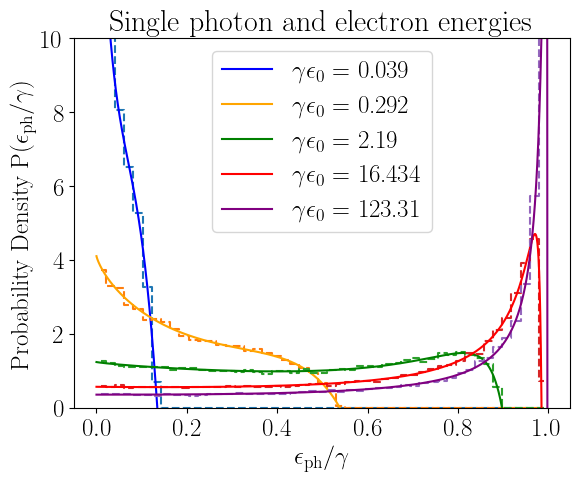

In [43]:
# Qualitative sampling accuracy estimate. Change electron and photon energies as desired.
# Note: the network always accepts energies in log10 space.

listOfColors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
n_samples = 50_000

N = 100_000
x_lin = np.linspace(0,1,N)

gammaExpList = np.linspace(3.6, 7.101, 5)
# photonExpList = np.array([-7.0,-4.0])
photonExpList = np.array([-5.01])
for i in range(len(gammaExpList)):
    for j in range(len(photonExpList)):
        gammaExp = gammaExpList[i]
        photonExp = photonExpList[j]
        gamma = 10**gammaExp
        photonEnergy = 10**photonExp
        outMax = outMax_fn(10**gammaExp, 10**photonExp)
        out= nnsample(n_samples, gammaExp, photonExp, device=device)
        out = out / gamma
        num_bins=50
        bins = np.linspace(0, 1, num_bins)
        h, _ = np.histogram(out, bins=bins, density=True)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        plt.step(bin_centers, h, linestyle='dashed', where='mid')
        x_axis = np.logspace(photonExp, np.log10(outMax), N)
        outgoingEnergy = x_axis
        pdf = scatteringRate_iso(x_axis, gamma, photonEnergy)
        pdf_area = np.trapz(pdf, x_axis/gamma)
        pdf /= pdf_area
        ge = gamma * photonEnergy
        energyString = str(np.round(ge, 3))
        plt.plot(x_axis / gamma, pdf, color=listOfColors[i + 2*j], label = r'$\gamma\epsilon_0$ = ' + energyString)

plt.ylim(0, 10)

plt.rcParams.update({'font.size': 18})

plt.xlabel(r'$\epsilon_\mathrm{ph}/\gamma$')
plt.ylabel(r'Probability Density P($\epsilon_\mathrm{ph}/\gamma$)')
plt.legend()
plt.title('Single photon and electron energies')
plt.show()

In [9]:
# net.eval()
# net = net.cpu()
# print(net)

In [45]:
# Write all the weights and biases to txt files.
# This is just for loading parameters into the CUDA script. The convention is my own, and not necessarily standard. 

with open('net1_layer0.txt', 'w') as f:
    count = 0
    for entry in np.array(net.layers[0].weight.data):
        f.write(str(entry[0]))
        f.write(' ')
        count += 1
        # print(count)
    for entry in np.array(net.layers[0].weight.data):
        f.write(str(entry[1]))
        f.write(' ')
        count += 1
        # print(count)
    for entry in np.array(net.layers[0].weight.data):
        f.write(str(entry[2]))
        f.write(' ')
        count += 1
        # print(count)
    f.write('\n')
    for entry in np.array(net.layers[0].bias.data):
        f.write(str(entry))
        f.write('\n')

with open('net1_layer1.txt', 'w') as f:
    for line in np.array(net.layers[2].weight.data):
        line = line.tolist()
        for entry in line:
            f.write(str(entry) + ' ')
    f.write('\n')
    for entry in np.array(net.layers[2].bias.data):
        f.write(str(entry))
        f.write('\n')

with open('net1_layer2.txt', 'w') as f:
    for line in np.array(net.layers[4].weight.data):
        line = line.tolist()
        for entry in line:
            f.write(str(entry) + ' ')
    f.write('\n')
    for entry in np.array(net.layers[4].bias.data):
        f.write(str(entry))
        f.write('\n')

with open('net1_layer3.txt', 'w') as f:
    for line in np.array(net.layers[6].weight.data):
        line = line.tolist()
        for entry in line:
            f.write(str(entry) + ' ')
    f.write('\n')
    for entry in np.array(net.layers[6].bias.data):
        f.write(str(entry))
        f.write('\n')
